In [27]:
# TensorFlow and tf.keras

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
import tensorflow.keras.utils
import pandas as pd

# import keras
# import keras.backend
# from keras import layers
# from keras import models
# import keras.utils

print(tf.__version__)

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import math
import time
import h5py
import sklearn
from sklearn.utils import shuffle

import os

2.0.0


## Import data

In [30]:
data = np.load('/mnt/data/ml/ShowJetsData1.npz')
# !ls /mnt/data/ml/
images = data['jetImages']
labels = data['labels']
grid = np.size(images, 1)
#ensure same number of signal vs. background and even split of z events
qcd_im = images[np.where(labels[:,0] == 1)]
if len(qcd_im) % 3 != 0:
    qcd_im = qcd_im[:len(qcd_im)-(len(qcd_im) % 3)]
z1_im = images[np.where(labels[:,1] == 1)]
z1_im = z1_im[:int(len(qcd_im)/3)]
z2_im = images[np.where(labels[:,2] == 1)]
z2_im = z2_im[:int(len(qcd_im)/3)]
z3_im = images[np.where(labels[:,3] == 1)]
z3_im = z3_im[:int(len(qcd_im)/3)]
print(len(z1_im), len(z2_im), len(z3_im), len(qcd_im))
qcd_lab = np.zeros([len(qcd_im), 2])
qcd_lab[:,0] = 1
z_lab = np.zeros([len(qcd_im), 2])
z_lab[:,1] = 1
images = np.vstack((qcd_im, z1_im, z2_im, z3_im))
labels = np.vstack((qcd_lab, z_lab))
n_data = len(images)
images = images.reshape(n_data, grid, grid, 1)
#split data into testing/training/validation

testimages = images[::4]
testlabels = labels[::4]
mask_im = np.ones(images.shape,dtype=bool)
mask_im[::4] = 0
mask_im[1::8] = 0
mask_lab = np.ones(labels.shape,dtype=bool)
mask_lab[::4] = 0
mask_lab[1::8] = 0
valimages = images[1::8]
vallabels = labels[1::8]

trainimages = images[mask_im].reshape((n_data-len(testimages)-len(valimages)), grid, grid, 1)
trainlabels = labels[mask_lab].reshape((n_data-len(testimages)-len(valimages)), 2)

16540 16540 16540 49620


Print a plot of data to see what it looks like!

Preprocessing -> spit data into training and testing; take 80% for training and 20% for testing.

If using CNN, uncomment ".reshape(n_data, grid, grid, 1)".

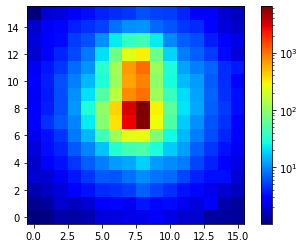

In [31]:
#plot input signal and background
sig_trainimages = np.zeros_like(trainimages[1])
bkg_trainimages = np.zeros_like(trainimages[1])
for i in range(len(trainimages)):
    if trainlabels[i,0] == 1:
        sig_trainimages += trainimages[i]
    else:
        bkg_trainimages += trainimages[i]
display_sig = sig_trainimages.reshape(grid,grid)
plt.grid(False)
plt.imshow(display_sig, interpolation='nearest', origin='low', cmap = 'jet', norm=LogNorm())
plt.colorbar()
plt.show()

Build DNN:

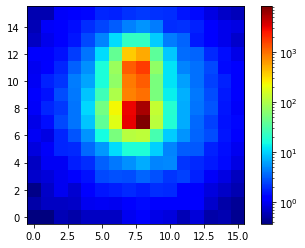

In [32]:
#background
display_bkg = bkg_trainimages.reshape(grid,grid)
plt.grid(False)
plt.imshow(display_bkg, interpolation='nearest', origin='low', cmap = 'jet', norm=LogNorm())
plt.colorbar()
plt.show()

In [33]:
def build_model():
    input1 = layers.Input(shape = (grid, grid, 1))
    x = layers.Conv2D(64, (12, 12), padding = 'same', activation='relu')(input1)
    x = layers.Conv2D(64, (6, 6), padding = 'same', activation='relu')(x)
    x = layers.Conv2D(64, (4, 4), padding = 'same', activation='relu')(x)
    x = layers.MaxPool2D((2, 2))(x)
    x = layers.Conv2D(32, (4, 4), padding = 'same', activation='relu')(x)
    x = layers.Conv2D(32, (3, 3), padding = 'same', activation='relu')(x)
    x = layers.Conv2D(32, (2, 2), padding = 'same', activation='relu')(x)
    x = layers.MaxPool2D((2, 2))(x)
#     x = layers.Conv2D(32, (6, 6), padding = 'same', activation='relu')(x)
#     x = layers.Conv2D(32, (4, 4), padding = 'same', activation='relu')(x)
#     x = layers.Conv2D(32, (4, 4), padding = 'same', activation='relu')(x)
#     x = layers.MaxPool2D((2, 2))(x)
    x = layers.Flatten()(x)
#     input2 = layers.Input(shape=(1,))
#     input3 = layers.Input(shape=(2,))
#     input4 = layers.Input(shape=(1,))
#     x = layers.concatenate(inputs = [x1, input2, input3, input4],axis=-1)
    x = layers.Dense(64, activation=tf.nn.relu)(x)
    x = layers.Dense(256, activation=tf.nn.relu)(x)
    x = layers.Dense(256, activation=tf.nn.relu)(x)
    output = layers.Dense(2, activation=tf.nn.softmax)(x)
    model = models.Model(inputs=input1, outputs=output)
    model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['categorical_crossentropy', 'accuracy'])
    return model

Initialize model:

In [34]:
CNN = build_model()

Test model's prediction $before$ training:

In [35]:
example_batch = trainimages[::300]
example_labels = trainlabels[::300]
# example_radii = trainradii[:10]
# example_theta = traintheta[:10]
# example_z = trainz[:10]
example_result = CNN.predict(x = example_batch)
results = CNN.evaluate(x = example_batch, y = example_labels, verbose = 0)
print(example_result)
print(results)

[[0.4997265  0.5002736 ]
 [0.4997444  0.50025564]
 [0.4997691  0.50023097]
 [0.4997054  0.5002946 ]
 [0.49973935 0.50026065]
 [0.49976456 0.5002355 ]
 [0.49975953 0.50024045]
 [0.49972975 0.50027025]
 [0.49980026 0.50019974]
 [0.49980047 0.5001995 ]
 [0.4997285  0.5002715 ]
 [0.49982148 0.5001785 ]
 [0.49974936 0.5002507 ]
 [0.49979833 0.50020164]
 [0.49978888 0.5002111 ]
 [0.49976793 0.50023204]
 [0.4996286  0.50037146]
 [0.49986967 0.5001304 ]
 [0.49980995 0.5001901 ]
 [0.49980724 0.5001927 ]
 [0.49977833 0.5002217 ]
 [0.49966908 0.500331  ]
 [0.49990472 0.50009525]
 [0.49988413 0.5001159 ]
 [0.49979594 0.50020397]
 [0.49977213 0.50022787]
 [0.49975228 0.5002477 ]
 [0.49980715 0.5001928 ]
 [0.4996868  0.5003132 ]
 [0.4996746  0.50032544]
 [0.49973193 0.50026804]
 [0.49978033 0.5002197 ]
 [0.49982262 0.50017744]
 [0.49968886 0.5003111 ]
 [0.49967963 0.5003203 ]
 [0.49967253 0.50032747]
 [0.49968207 0.50031793]
 [0.49976426 0.50023574]
 [0.49973968 0.50026035]
 [0.49977377 0.50022626]


Now train! (warning: if building CNN, computer tends to get loud)

In [ ]:
checkpoint_path = "model/CNN_images.h5"
if not os.path.exists("model"):
    os.mkdir("model")

# Create checkpoint callback
# cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
#                                                  save_best_only=True,
#                                                  verbose=1)
model_checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', 
                                   verbose=1, save_best_only=True, 
                                   save_weights_only=False, mode='auto')    
EPOCHS = 50
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = CNN.fit(
  trainimages, trainlabels,
  epochs=EPOCHS, validation_data = (valimages, vallabels), verbose = 0,
  callbacks=[early_stop, model_checkpoint])

Now make a plot that shows the pregression of accuracy through each training epoch.

In [9]:
# def plot_history(history):
#   hist = pd.DataFrame(history.history)
#   hist['epoch'] = history.epoch
  
#   plt.figure()
#   plt.xlabel('Epoch')
#   plt.ylabel('Mean Square Error')
#   plt.plot(hist['epoch'], hist['binary'],
#            label='Train Error')
#   plt.plot(hist['epoch'], hist['val_mean_squared_error'],
#            label = 'Val Error')
#   plt.ylim([0,100])
#   plt.legend()
#   plt.show()

# plot_history(history)

Load best weights.

In [65]:
!ls model
best_model = keras.models.load_model('model/CNN_normedpythia.h5')
best_model.summary()
results = best_model.evaluate(testimages, testlabels, verbose = 0)
print(results)

CNN1D_2cat.h5  CNN1D_v3.h5	    CNN_cat_multi_input.h5
CNN1D.h5       CNN_1TeVpythia.h5    CNN_normedpythia.h5
CNN1D_v2.h5    CNN_allTeVpythia.h5  CNN_pythia.h5
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 16, 16, 1)]       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 16, 64)        9280      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 16, 16, 64)        147520    
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 16, 16, 64)        65600     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_15 (Conv2D)           (N

Evaluate the performance of our DNN! Plot predictions vs. true values (the line is predictions vs. predicitons).

In [66]:
predict = best_model.predict(testimages)

[1. 1. 1. ... 0. 0. 0.]
[0.69839704 0.80837226 0.8746229  ... 0.26622882 0.83603865 0.79028076]


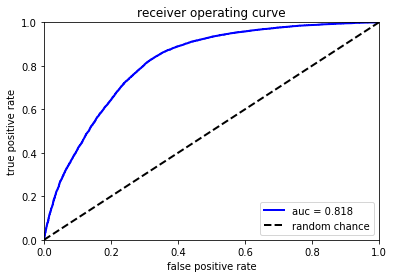

In [68]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(testlabels[:,1], predict[:,1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='b', label='auc = %.3f' % (roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
plt.xlim([0, 1.0])
plt.ylim([0, 1.0])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('receiver operating curve')
plt.legend(loc="lower right")
plt.show()

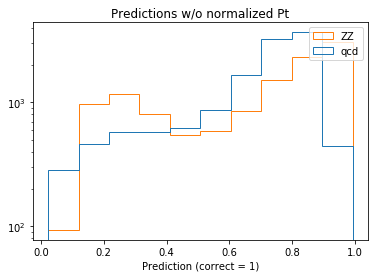

In [69]:
indqcd = np.argwhere(testlabels[:,1] == 0)
ind1  = np.where(testlabels[:,1] == 1) 
# ind2  = np.where(testlabels[:,2] == 1)
# ind3  = np.where(testlabels[:,3] == 1)
hist_, bin_edges_ = np.histogram(predict[indqcd])
plt.hist([predict[indqcd, 0].flatten(),predict[ind1, 1].flatten()] , histtype = 'step', label = ['qcd', 'ZZ'])
plt.legend()
plt.title('Predictions w/o normalized Pt')
plt.yscale('log')
plt.xlabel('Prediction (correct = 1)')
plt.show()